In [118]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx 

In [269]:
#set paths 
STORMS_PATH  = "/shared/3/projects/newsDiffusion/data/processed/stormDfs/20000_90_storms.tsv"
ARTICLES_PATH = "/shared/3/projects/newsDiffusion/data/processed/fullDataWith20000.tsv"

VER_2020 = "/shared/3/projects/newsDiffusion/data/raw/NELA-gt-2020/labels.csv"
VER_2021 = "/shared/3/projects/newsDiffusion/data/raw/NELA-gt-2021/labels_all.tab"

In [3]:
stormsDf = pd.read_csv(STORMS_PATH, sep="\t")
artDf = pd.read_csv(ARTICLES_PATH, sep="\t")

<ipython-input-3-7444354899f0>:2: DtypeWarning: Columns (4,5,12,13,15,16,19) have mixed types. Specify dtype option on import or set low_memory=False.
  artDf = pd.read_csv(ARTICLES_PATH, sep="\t")


In [11]:
merged = pd.merge(artDf, stormsDf[['key','20000_90_average_pct','20000_90_num_over_cutoff',\
                          '20000_90_storm_source', '20000_90_storm']], on="key", how="left")

In [1268]:
merged.shape

(4567468, 54)

In [14]:
SCOL = "20000_90"

In [1853]:
stormRows = merged.loc[merged[SCOL + "_storm"] == True]

In [1854]:
stormRows["date"] = pd.to_datetime(stormRows["date"])

<ipython-input-1854-df3dd340f2f9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stormRows["date"] = pd.to_datetime(stormRows["date"])


In [1855]:
from tqdm import tqdm

In [1856]:
sourceEdges = {}

WINDOW = 3
currVal = 47806.0

#for sanity check: for currVal in tqdm(list(stormRows[SCOL].unique())[:1]): 
for currVal in tqdm(list(stormRows[SCOL].unique())):
    currStorm = stormRows.loc[stormRows[SCOL] == currVal, ["date", "key", "source"]].set_index("date")
    currStorm["dateCol"] = currStorm.index
    
    #for sanity check  
    #currStorm = currStorm.sample(20, random_state=13).sort_values("date")
    
    #sanity check: remove an outlet from first day and see if 
    #pick it up as influential on its next occurence 
    #this removes start tribune from storm at index 5
    #currStorm = currStorm[currStorm["key"] != 65302]
    
    minDay = min(currStorm.index)
    maxDay = max(currStorm.index)

    #get all of the starting dates for the date windows we need 
    possibleDates = pd.date_range(minDay, maxDay -  np.timedelta64(WINDOW-1, "D"),freq='d')
    
    #keep track of which outlets have occured in the storm 
    #iterate through the storm in WINDOW sized windows 
    inStorm = {}
    stormEdges = {}
    for date in possibleDates: 
        
        #get rows in our date time range 
        #sorting makes sure we get "first pair" of outlet influence
        dateRows = currStorm[date : date + np.timedelta64(WINDOW-1, "D")].sort_values("date")
    
        #iterate through every pair in current 3-day window 
        for i in range(len(dateRows)): 
            l = dateRows.iloc[i]
            lDate = l["dateCol"]
            
            for j in range(i+1, len(dateRows)):
                
                
                r = dateRows.iloc[j]
                rDate = r["dateCol"] 
                
                #don't consider self-influence 
                if (l["source"] != r["source"]): 
                    
                    #an edge can only be influenced if it hasn't occured yet in the storm 
                    if r["source"] not in inStorm: 

                        #add to edgeDict 
                        sTup = (l["source"], r["source"])
                        revTup = (r["source"], l["source"])
                        
                        #if we haven't added this to the storm's edge count
                        #note that this really means for the 3-day window 
                        #so we don't double count anything 
                        if sTup not in stormEdges and revTup not in stormEdges: 
                            
                            #for same date, we add to dictionary since we've considered this influence 
                            #but we don't want to add an influence link so call this zero 
                            if lDate == rDate: 
                                stormEdges[sTup] = 0
                                
                                #reverse edge should also not be added again and should be zero 
                                stormEdges[revTup] = 0 
                            else: 
                                stormEdges[sTup] = 1
                            
            #after we've considered every pair that this outlet goes to 
            #we can add it to inStorm. Remember, if this outlet has appeared in our 
            #loop then we've already considered every outlet that has occured before it 
            #in a 3-day window 
            inStorm[l["source"]] = True
        
    #once we've gone through a storm, dump influence edges into sourceEdges 
    for edge in list(stormEdges.keys()): 
        if edge not in sourceEdges: 
            sourceEdges[edge] = 1
        else: 
            sourceEdges[edge] += 1

100%|██████████| 98/98 [05:50<00:00,  3.58s/it]


In [1857]:
"""
for sanity check (uncomment up above)
inStorm
possibleDates
currStorm
stormEdges
#for debugging 
"""


'\nfor sanity check (uncomment up above)\ninStorm\npossibleDates\ncurrStorm\nstormEdges\n#for debugging \n'

In [1858]:
"""
artEdges = {}
sourceEdges = {}

WINDOW = 3
currVal = 47806.0

for currVal in tqdm(list(stormRows[SCOL].unique())): 

    currStorm = stormRows.loc[stormRows[SCOL] == currVal, ["date", "key", "source"]].set_index("date")
    currStorm["dateCol"] = currStorm.index
    minDay = min(currStorm.index)
    maxDay = max(currStorm.index)

    #get all of the starting dates for the date windows we need 
    possibleDates = pd.date_range(minDay, maxDay -  np.timedelta64(WINDOW-1, "D"),freq='d')

    for date in possibleDates: 

        #get rows in our date time range 
        dateRows = currStorm[date : date + np.timedelta64(WINDOW-1, "D")].sort_values("date")
        
        for i in range(len(dateRows)): 
            for j in range(i+1, len(dateRows)):
                l = dateRows.iloc[i]
                r = dateRows.iloc[j]
                
                #we are going through sorted rows, so as long as we remove same day 
                #edges we're fine 
                if l["dateCol"] != r["dateCol"]: 
                    #if we haven't already counted this edge 
                    artTup = (l["key"], r["key"])
                    if artTup not in artEdges: 

                        #if this edge isn't in source dict add it
                        #else, add 1 to its edge 
                        sTup = (l["source"], r["source"])
                        if sTup not in sourceEdges: 
                            sourceEdges[sTup] = 1
                        else: 
                            sourceEdges[sTup] += 1

                        artEdges[artTup] = True
"""

'\nartEdges = {}\nsourceEdges = {}\n\nWINDOW = 3\ncurrVal = 47806.0\n\nfor currVal in tqdm(list(stormRows[SCOL].unique())): \n\n    currStorm = stormRows.loc[stormRows[SCOL] == currVal, ["date", "key", "source"]].set_index("date")\n    currStorm["dateCol"] = currStorm.index\n    minDay = min(currStorm.index)\n    maxDay = max(currStorm.index)\n\n    #get all of the starting dates for the date windows we need \n    possibleDates = pd.date_range(minDay, maxDay -  np.timedelta64(WINDOW-1, "D"),freq=\'d\')\n\n    for date in possibleDates: \n\n        #get rows in our date time range \n        dateRows = currStorm[date : date + np.timedelta64(WINDOW-1, "D")].sort_values("date")\n        \n        for i in range(len(dateRows)): \n            for j in range(i+1, len(dateRows)):\n                l = dateRows.iloc[i]\n                r = dateRows.iloc[j]\n                \n                #we are going through sorted rows, so as long as we remove same day \n                #edges we\'re fine \

In [1859]:
#get sources, veracity scores in a dataframe
ver2020 = pd.read_csv(VER_2020, sep=",")
ver2021 = pd.read_csv(VER_2021, sep="\t")

In [1860]:
#we want [0, 1] -> 2, [2, 3] -> 1, [4, 5] -> 0
#didn't actually do this to keep consistency between datasets 
#ver2021["label"] = pd.cut(ver2021["factuality"], bins=[0, 1.1, 3.1, 5.1], labels=[2, 1, 0]).astype(float)

In [1861]:
ver2021[ver2021["source"] == "cnn"]

,source,country,label,bias,factuality,questionable-source,conspiracy-pseudoscience,pro-science
52,cnn,USA,2,left,2.0,0,0,0


In [1862]:
#for 2020 - reliable is 0, mixed is 2, and unreliable is 1
#plt.hist(ver2020["label"])

In [1863]:
#again in NELA 2021, 0 is reliable, 2 is mixed, and 1 is unreliable 
#sns.scatterplot(data=ver2021, x="label", y="factuality")

In [1864]:
#fill na in 2021 with 2020 ratings 
sourceDf = pd.merge(ver2020, ver2021[["source","label"]], on="source", how="outer")
sourceDf["label"] = sourceDf["label_y"].fillna(sourceDf["label_x"])

#get local/national labels 
localNat = artDf[["source", "national"]].drop_duplicates()
sourceDf = pd.merge(sourceDf, localNat, on="source", how="outer")

(array([  4.,   0.,   0., 117.,   0.,   0., 218.,   0.,   0.,  49.]),
 array([-1. , -0.7, -0.4, -0.1,  0.2,  0.5,  0.8,  1.1,  1.4,  1.7,  2. ]),
 <BarContainer object of 10 artists>)

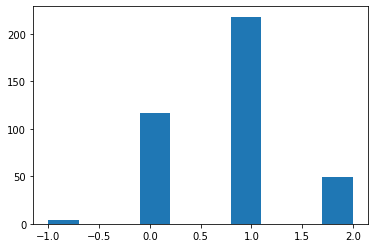

In [1865]:
#sanity check 
plt.hist(sourceDf["label"])

In [1866]:
#makes much more sense to flip  1 and 2 around so 1 is mixed and 2 is extreme 
sourceDf["label"] = sourceDf["label"].replace({1:2, 2:1})

(array([  4.,   0.,   0., 117.,   0.,   0.,  49.,   0.,   0., 218.]),
 array([-1. , -0.7, -0.4, -0.1,  0.2,  0.5,  0.8,  1.1,  1.4,  1.7,  2. ]),
 <BarContainer object of 10 artists>)

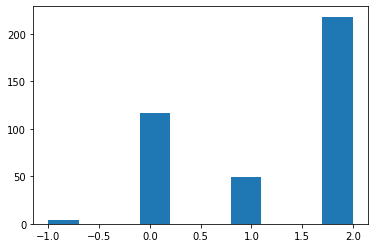

In [1867]:
#sanity check 
plt.hist(sourceDf["label"])

In [1868]:
#we want outlets with both local and national classification to be local 
sourceDf = sourceDf.sort_values("national").drop_duplicates(subset=["source"])

In [1869]:
sourceDf.loc[(sourceDf["source"] == "charlotteobserver"), ["national"]] = False

In [1870]:
#merge everything under the "label" category
#here, 4 means local 
sourceDf.loc[sourceDf["national"] == False, "label"] = 3

#only item with a -1 reliability that matters/is relevant is forbes... 
#should be rated "reliable"
sourceDf.loc[sourceDf["source"] == "forbes", "label"] = 0

#if we have nat/local duplicates, call them local 
sourceDf = sourceDf.sort_values("national").drop_duplicates(subset=["source"])

sourceDf["label"] = sourceDf["label"].fillna(4)

#sanity check 
sourceDf["label"].value_counts()

label
 3.0    314
 2.0    218
 4.0    173
 0.0    108
 1.0     49
-1.0      3
Name: count, dtype: int64

In [1871]:
sourceDf[sourceDf["source"] == "charlotteobserver"]

,source,label_x,label_y,label,national
216,charlotteobserver,0.0,0.0,3.0,False


In [1872]:
merged.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'key', 'local_id',
       'sourcedomain_id', 'date', 'title', 'content', 'url', 'fips', 'source',
       'description', 'onlinesince', 'rank', 'state', 'city', 'lon', 'lat',
       'county', 'total_population', 'white_pct', 'black_pct', 'hispanic_pct',
       'nonwhite_pct', 'foreignborn_pct', 'female_pct', 'age29andunder_pct',
       'age65andolder_pct', 'median_hh_inc', 'clf_unemploy_pct', 'lesshs_pct',
       'lesscollege_pct', 'lesshs_whites_pct', 'lesscollege_whites_pct',
       'rural_pct', 'ruralurban_cc', 'predrt_0', 'predrt_12', 'predrt_3',
       'national', 'id', 'author', 'published', 'published_utc',
       'collection_utc', '20000_80', '20000_85', '20000_90', 'year',
       '20000_90_average_pct', '20000_90_num_over_cutoff',
       '20000_90_storm_source', '20000_90_storm'],
      dtype='object')

In [1873]:
stormRows = pd.merge(stormRows, sourceDf[["source", "label"]], on="source", how="left")

In [1874]:
#get edges,weights from our algo above and put in dataframe 
sourceTups = list(sourceEdges.keys())
sourceLeft = [tup[0] for tup in sourceTups]
sourceRight = [tup[1] for tup in sourceTups]
sourceWeights = [sourceEdges[tup] for tup in sourceTups]

edgeDf = pd.DataFrame({"first":sourceLeft, "second":sourceRight, "weight":sourceWeights})
edgeDf = edgeDf.sort_values("weight", ascending=False)

#remove self-edges
edgeDf  = edgeDf[edgeDf["first"] != edgeDf["second"]]

In [1875]:
#get top sources according to CUTOFF 
CUTOFF = 30
sourceCounts = pd.DataFrame(stormRows[["source"]].value_counts()).reset_index()
topSources = list(sourceCounts.head(CUTOFF)["source"])

#get all edges between top sources 
topEdgeDf = edgeDf[(edgeDf["first"].isin(topSources)) & edgeDf["second"].isin(topSources)]

In [1876]:
#create graph 
G = nx.from_pandas_edgelist(topEdgeDf, source="first", target="second", edge_attr="weight", create_using=nx.DiGraph)

'\nverticalalignment="bottom",\nhorizontalalignment="right"\n'

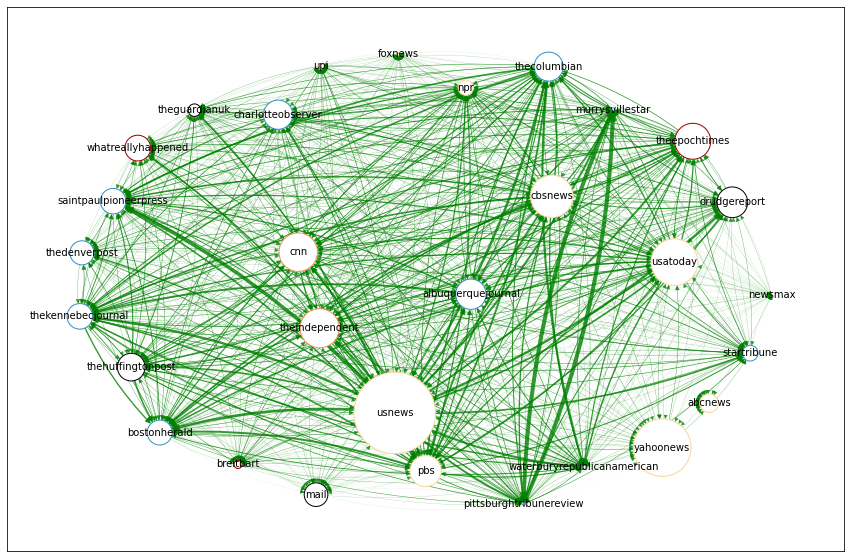

In [1877]:
fig, ax = plt.subplots(figsize=(15, 10))
pos = nx.spring_layout(G, seed=10, k=14)

edges = G.edges()

#get/scale weights 
weights = [G[u][v]['weight'] for u,v in edges]
weights = list(nx.get_edge_attributes(G,'weight').values())
ampWeights = [item**4 for item in weights]
minWeight = min(ampWeights)
maxWeight = max(ampWeights)
scaledWeights = [((item - minWeight) / maxWeight)*4 for item in ampWeights]

#alpha values
alphas = [np.cbrt(item) for item in weights]
scaledAlphas= [((item - min(alphas)) / max(alphas)) for item in alphas]

#get node sizes
nodeSizes = [sourceCounts.set_index("source").loc[item].iloc[0] for item in list(G.nodes())]
ampSizes = [item**2 for item in nodeSizes]
scaledSizes = [((item - min(ampSizes)) / max(ampSizes))*7000 for item in ampSizes]

#get colors for nodes
sourceLookup = sourceDf.set_index("source")
palette = ["#fdd49e", "#fc8d59", "#990000", "#3690c0", "black"]
nodeColors = [palette[sourceLookup.loc[source]["label"].astype(int)] for source in list(G.nodes())]

nodes = nx.draw_networkx_nodes(G, pos, 
        edgecolors=nodeColors,
        node_color="white",
        node_size=scaledSizes)

nx.draw_networkx_edges(G, pos, node_size=scaledSizes,width=scaledWeights, alpha=.8, connectionstyle='arc3, rad=0.1',arrows=True,edge_color="green")

nx.draw_networkx_labels(G, pos, font_size=10)
"""
verticalalignment="bottom",
horizontalalignment="right"
"""


## Scaled by so-called "influence"

In [2063]:
#get top sources according to CUTOFF 
CUTOFF = 20

#this shouldn't be in national news.. 
avoidList = ["talkingpointsmemo", "dailyheraldchicago"]

sourceCounts = pd.DataFrame(stormRows.loc[(~stormRows["source"].isin(avoidList)) &  (stormRows["national"] == True) & (stormRows["label"] == 0), ["source"]].value_counts()).reset_index()
topSources = list(sourceCounts.head(CUTOFF)["source"])

#get all edges between top sources 
topEdgeDf = edgeDf[(edgeDf["first"].isin(topSources)) & edgeDf["second"].isin(topSources)]

#create graph 
G = nx.from_pandas_edgelist(topEdgeDf, source="first", target="second", edge_attr="weight", create_using=nx.DiGraph)

In [2064]:
outWeights = []
outDiffs = []
for node in G.nodes():
    totalOut = sum([G.edges[edge[0], edge[1]]["weight"] for edge in G.out_edges([node])])
    totalIn = sum([G.edges[edge[0], edge[1]]["weight"] for edge in G.in_edges([node])])
    outWeights.append(totalOut)
    outDiffs.append(totalOut - totalIn)
    
nx.set_node_attributes(G, dict(zip(G.nodes(), outWeights)), name="outWeight")
nx.set_node_attributes(G, dict(zip(G.nodes(), outDiffs)), name="outDiffs")

In [2065]:
import random

FIG_PATH = "/home/blitt/projects/localNews/reports/figures/drafts/"
random.seed(12)
PALETTE = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf']*2 + ['#ff7f00','#ffff33','#a65628','#f781bf']
random.shuffle(PALETTE)

In [2066]:
#for colors 
outletLookup = dict(zip(list(G.nodes()), PALETTE*2 + ['#4daf4a','#984ea3','#a65628','#f781bf']))

In [2067]:
G.nodes()

NodeView(('usnews', 'pbs', 'cbsnews', 'usatoday', 'npr', 'upi', 'thenewyorktimes', 'nationalreview', 'france24', 'yahoonews', 'slate', 'cnbc', 'skynewsus', 'thehill', 'eveningstandard', 'vox', 'newsweek', 'abcnews', 'bbc', 'thetorontostar'))

In [2068]:
newNodeNames = {'usnews':"U.S. News", "pbs":"PBS", "usatoday":"U.S.A Today", "npr":"NPR", "upi":"UPI", "thenewyorktimes":"New York Times",
               'latimes':"L.A. Times", "france24":"France 24", "yahoonews":"Yahoo News", "slate":"Slate", "skynewsus":"Sky News U.S", 
                "eveningstandard":"Evening Standard", "politico":"Politico", "mcclatchydc":"McClatchy D.C", "abcnews":"ABC News", "politicalwire":"Political Wire",
               "bbc":"BBC", "thetorontostar":"The Toronto Star", "washingtonpost":"Washington Post", "cbsnews":"CBS News", 
               "cnbc":"CNBC", "thehill":"The Hill", "eveningstandard":"Evening Standard", "Vox":"vox", "newsweek":"Newsweek", "nationalreview":"National Review",
               "vox":"Vox"}

newNames = {item:newNodeNames[item] for item in list(G.nodes())}

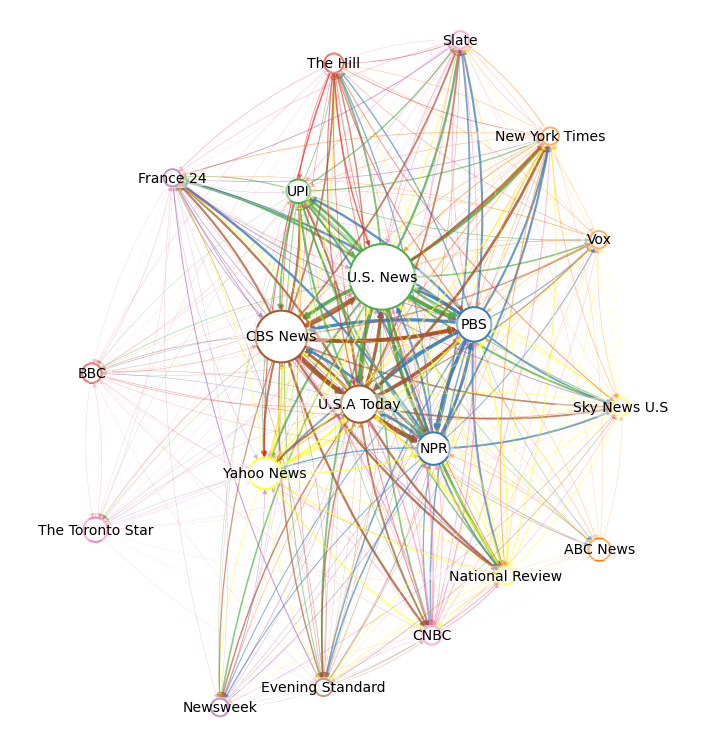

In [2076]:
fig, ax = plt.subplots(figsize=(10, 10.5))
pos = nx.spring_layout(G, seed=20, k=8)

edges = G.edges()

#which nudges to make for which outlets 
#nudgeDict = {"eveningstandard":[0, .1]}

nudged = {}
for k,v in pos.items(): 
    if k in nudgeDict: 
        nudgeX = nudgeDict[k][0]
        nudgeY = nudgeDict[k][1]
        v[0] +=  nudgeX
        v[1] += nudgeY
    outPos = v
    nudged[k] = outPos
    
#get/scale weights 
weights = [G[u][v]['weight'] for u,v in edges]
weights = list(nx.get_edge_attributes(G,'weight').values())

#a lower power gives a smaller spread of weight
ampWeights = [item**1.4 for item in weights]
minWeight = min(ampWeights)
maxWeight = max(ampWeights)
scaledWeights = [((item - minWeight) / (maxWeight-minWeight))*4 for item in ampWeights]

def nthroot(a,n):
    return np.power(a,(1/n))


edgeColors = [outletLookup[edge[0]] for edge in list(edges)]
nodeColors = [outletLookup[node] for node in list(G.nodes())]

#alpha values
alphas = [nthroot(item, 2) for item in weights]
scaledAlphas= [(item - min(alphas)) / (max(alphas) - min(alphas)) for item in alphas]

#get node sizes
FLOOR_SIZE = 300
nodeSizes = list(nx.get_node_attributes(G, "outDiffs").values())
ampSizes = [(item - min(nodeSizes))**4 for item in nodeSizes]
scaledSizes = [((item - min(ampSizes)) / (max(ampSizes) - min(ampSizes))*4000) + FLOOR_SIZE for item in ampSizes]



#get colors for nodes
sourceLookup = sourceDf.set_index("source")
palette = ["#fdd49e", "#fc8d59", "#990000", "#3690c0", "black"]
#nodeColors = [palette[sourceLookup.loc[source]["label"].astype(int)] for source in list(G.nodes())]

nodes = nx.draw_networkx_nodes(G, pos, 
        edgecolors=nodeColors,
        node_color="white",
        node_size=scaledSizes,
        linewidths=2)

nx.draw_networkx_edges(G, pos, node_size=scaledSizes, width=scaledWeights, alpha=scaledAlphas, connectionstyle='arc3, rad=0.1',arrows=True, edge_color=edgeColors)

nx.draw_networkx_labels(G, nudged, labels=newNames, font_size=14, bbox=dict(facecolor = "white", edgecolor="white", pad=0, boxstyle="ellipse", alpha=.4))
"""
verticalalignment="bottom",
horizontalalignment="right"
"""
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.margins(y=0, x=.1)
plt.tight_layout()
plt.savefig(FIG_PATH + "mainstreamGraph.pdf", bbox_inches="tight")

In [2075]:
G.nodes()

NodeView(('usnews', 'pbs', 'cbsnews', 'usatoday', 'npr', 'upi', 'thenewyorktimes', 'nationalreview', 'france24', 'yahoonews', 'slate', 'cnbc', 'skynewsus', 'thehill', 'eveningstandard', 'vox', 'newsweek', 'abcnews', 'bbc', 'thetorontostar'))

In [2074]:
list(nx.get_node_attributes(G, "outDiffs").values())

[226,
 107,
 180,
 120,
 97,
 38,
 -138,
 -48,
 -148,
 92,
 -152,
 -29,
 -113,
 -13,
 -136,
 -86,
 -57,
 26,
 -10,
 44]

In [2071]:
outWeights

[729,
 644,
 675,
 650,
 595,
 468,
 310,
 398,
 298,
 473,
 276,
 346,
 297,
 340,
 244,
 230,
 217,
 193,
 195,
 207]

In [2070]:
nodeSizes

[226,
 107,
 180,
 120,
 97,
 38,
 -138,
 -48,
 -148,
 92,
 -152,
 -29,
 -113,
 -13,
 -136,
 -86,
 -57,
 26,
 -10,
 44]

(array([ 2., 14., 21., 64., 92., 56., 46., 46., 21., 14.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

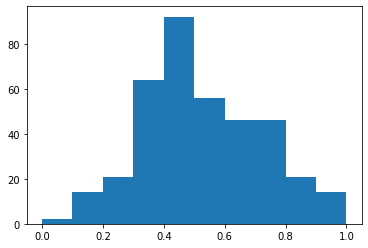

In [1902]:
#alpha values
alphas = [nthroot(item, 3) for item in weights]
scaledAlphas= [(item - min(alphas)) / (max(alphas) - min(alphas)) for item in alphas]

plt.hist(scaledAlphas)

(array([ 2., 14., 21., 64., 92., 56., 46., 46., 21., 14.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

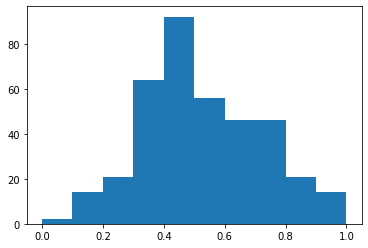

In [1903]:
#alpha values
#alphas = [nthroot(item, 10) for item in weights]
#scaledAlphas= [(item - min(alphas)) / (max(alphas) - min(alphas)) for item in alphas]

plt.hist(scaledAlphas)

In [1904]:
#now, let's look at the pagerank centrality here!
#get top 100 outlets  
CUTOFF = 100
sourceCounts = pd.DataFrame(stormRows[["source"]].value_counts()).reset_index()
topSources = list(sourceCounts.head(CUTOFF)["source"])

#get all edges between top sources 
topEdgeDf = edgeDf[(edgeDf["first"].isin(topSources)) & edgeDf["second"].isin(topSources)]

#create graph 
G = nx.from_pandas_edgelist(topEdgeDf, source="first", target="second", edge_attr="weight", create_using=nx.DiGraph)

In [1905]:
#centrality time
#we reverse the edges because we see reporting after an outlet as referring back to it!

#nx.pagerank(G.reverse())
hubs, authorities = nx.hits(G, max_iter=300)

/opt/anaconda/lib/python3.8/site-packages/networkx/algorithms/link_analysis/hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


In [1906]:
hubDf = pd.DataFrame.from_dict(hubs, orient="index", columns=["hubs"])
authDf = pd.DataFrame.from_dict(authorities, orient="index", columns=["authorities"])

hubAuth = pd.merge(hubDf.reset_index(), authDf.reset_index(), on="index").rename(columns={"index":"source"})
hubAuth["diff"] = hubAuth["hubs"] - hubAuth["authorities"]

In [1907]:
#once again we see that the larger outlets are more central 
hubAuth.sort_values("diff", ascending=False).head(10)

,source,hubs,authorities,diff
2,usnews,0.022781,0.013612,0.009170
14,cbsnews,0.020330,0.013039,0.007292
17,thehuffingtonpost,0.018809,0.012127,0.006682
15,usatoday,0.019803,0.013773,0.006030
10,pbs,0.020083,0.014111,0.005973
22,npr,0.018113,0.013434,0.004679
46,yahoonews,0.014186,0.009569,0.004617
61,newsmax,0.011992,0.007643,0.004349
27,charlotteobserver,0.016839,0.012577,0.004262
48,washingtontimes,0.012843,0.009125,0.003718


(array([ 6.,  8.,  6.,  9.,  9., 15., 14., 17., 11.,  5.]),
 array([0.00177871, 0.00327825, 0.00477778, 0.00627731, 0.00777684,
        0.00927637, 0.0107759 , 0.01227544, 0.01377497, 0.0152745 ,
        0.01677403]),
 <BarContainer object of 10 artists>)

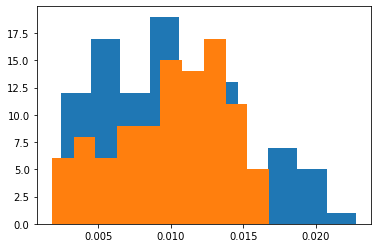

In [1908]:
#confirms that hubs and authorities have similar distribution
plt.hist(hubAuth["hubs"])
plt.hist(hubAuth["authorities"])

In [1909]:
stormRows["label"] 

0        3.0
1        3.0
2        3.0
3        3.0
4        3.0
        ... 
20326    3.0
20327    2.0
20328    0.0
20329    4.0
20330    2.0
Name: label, Length: 20331, dtype: float64

In [2077]:
#now do this for just four bubbles, one for each type of media 
#grab the top outlets in terms of publishing 

#get top outlets   
CUTOFF = 200
sourceCounts = pd.DataFrame(stormRows.loc[(stormRows["label"] != -1) & (stormRows["label"] != 4), "source"].value_counts()).reset_index()
topSources = list(sourceCounts.head(CUTOFF)["source"])

#get all edges between top sources 
topEdgeDf = edgeDf[(edgeDf["first"].isin(topSources)) & edgeDf["second"].isin(topSources)]


In [2078]:
print(f'Top {CUTOFF} outlets in storms:')
print(f'min stories published {min(sourceCounts.head(CUTOFF)["count"])}')
print(f'max stories published {max(sourceCounts.head(CUTOFF)["count"])}')

Top 200 outlets in storms:
min stories published 13
max stories published 750


In [2079]:
sourcePairs = pd.merge(topEdgeDf, sourceDf[["source","label"]], left_on="first", right_on="source").drop(columns=["source"])
sourcePairs = pd.merge(sourcePairs, sourceDf[["source", "label"]], left_on="second", right_on="source").drop(columns=["source"])

sourcePairs = sourcePairs.drop(columns=["first", "second"]).groupby(["label_x", "label_y"]).agg(sum).reset_index()

sourcePairs = sourcePairs.replace({0:"reliable", 1:"mixed", 2:"unreliable", 3:"local", 4:"national no label"})

In [2080]:
#create graph 
G = nx.from_pandas_edgelist(sourcePairs, source="label_x", target="label_y", edge_attr="weight", create_using=nx.DiGraph)

G.remove_edges_from(nx.selfloop_edges(G))

In [2081]:
outWeights = []
outDiffs = []
for node in G.nodes():
    totalOut = sum([G.edges[edge[0], edge[1]]["weight"] for edge in G.out_edges([node])])
    totalIn = sum([G.edges[edge[0], edge[1]]["weight"] for edge in G.in_edges([node])])
    outWeights.append(totalOut)
    outDiffs.append(totalOut - totalIn)
    
nx.set_node_attributes(G, dict(zip(G.nodes(), outWeights)), name="outWeight")
nx.set_node_attributes(G, dict(zip(G.nodes(), outDiffs)), name="outDiffs")

In [2082]:

normedWeights = []
#we want to try scaling the edges by their number of stories 
for edge in nx.edges(G): 
    thisEdge = G.edges[edge[0], edge[1]]["weight"]
    oppEdge = G.edges[edge[1], edge[0]]["weight"]
    #newEdge = thisEdge / (thisEdge + oppEdge)
    newEdge = thisEdge / oppEdge 
    normedWeights.append(newEdge)
    
#rescale to between 0 and 1    
normedWeights = [(item - min(normedWeights))/ (max(normedWeights) - min(normedWeights)) for item in normedWeights]


In [2083]:
palette = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6']

In [2084]:
nodeColors = palette

In [2085]:
typeLookup = dict(zip(list(G.nodes()), palette))

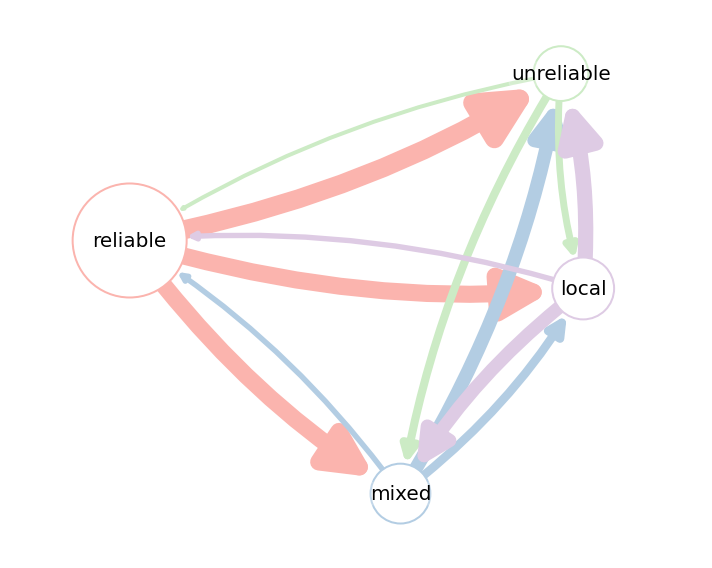

In [2095]:
fig, ax = plt.subplots(figsize=(10, 8))
pos = nx.spring_layout(G, seed=12, k=15)

edges = G.edges()

#which nudges to make for which outlets 
#nudgeDict = {"national no label":[0, .05], "mixed":[.03, .03]}

nudged = {}
for k,v in pos.items(): 
    if k in nudgeDict: 
        nudgeX = nudgeDict[k][0]
        nudgeY = nudgeDict[k][1]
        nudged[k] = (v[0] + nudgeX, v[1] + nudgeY)
    else: 
        nudged[k] = (v[0], v[1])
    
edgeColors = [typeLookup[edge[0]] for edge in list(edges)]
nodeColors = [typeLookup[node] for node in list(G.nodes())]

#get/scale weights 

normedWeights = []
#we want to try scaling the edges by their number of stories 
for edge in nx.edges(G): 
    thisEdge = G.edges[edge[0], edge[1]]["weight"]
    oppEdge = G.edges[edge[1], edge[0]]["weight"]
    #newEdge = thisEdge / (thisEdge + oppEdge)
    newEdge = thisEdge / oppEdge 
    normedWeights.append(newEdge)
    
#rescale to between 0 and 1    
normedWeights = [(item - min(normedWeights))/ (max(normedWeights) - min(normedWeights)) for item in normedWeights]
scaledWeights = [(item*15) + 4 for item in normedWeights]

arrowWeights = [(item*100) + 5 for item in normedWeights]
"""
weights = list(nx.get_edge_attributes(G,'weight').values())
ampWeights = [item for item in weights]
minWeight = min(ampWeights)
maxWeight = max(ampWeights)
scaledWeights = [((item - minWeight) / maxWeight)*8 for item in ampWeights]
scaledWeights = [(item*5) + 4 for item in normedWeights]

arrowWeights = [item * 4 for item in scaledWeights]
"""
#normedWeights = [(weight - min(weights)) / (max(weights) - min(weights)) for weight in weights]
#scaledWeights = [(weight * 5) + 2 for weight in normedWeights]
#get node sizes
FLOOR_SIZE = 3000
nodeSizes = list(nx.get_node_attributes(G, "outDiffs").values())
ampSizes = [(item - min(nodeSizes))**4 for item in nodeSizes]
scaledSizes = [(((item - min(ampSizes)) / max(ampSizes))*10000) + FLOOR_SIZE for item in ampSizes]

nodes = nx.draw_networkx_nodes(G, pos, node_size=scaledSizes, linewidths=2, node_color="white", edgecolors=nodeColors)

#add back arrowsize = arrowweights
nx.draw_networkx_edges(G, pos, node_size=scaledSizes, width=scaledWeights, alpha=1, arrowsize = arrowWeights, connectionstyle='arc3, rad=0.1',arrows=True, edge_color=edgeColors)

nx.draw_networkx_labels(G, pos, font_size=20,bbox=dict(facecolor = "white", edgecolor="white", pad=.1, boxstyle="round", alpha=.2))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.margins(y=.1, x=.2)
plt.tight_layout()
plt.savefig(FIG_PATH + "typeGraph.pdf", bbox_inches="tight")

In [2093]:
outDiffs

[7523, -1724, -4657, -1142]

In [2088]:
list(G.edges())[4]

('mixed', 'unreliable')

In [2089]:
edgeColors

['#fbb4ae',
 '#fbb4ae',
 '#fbb4ae',
 '#b3cde3',
 '#b3cde3',
 '#b3cde3',
 '#ccebc5',
 '#ccebc5',
 '#ccebc5',
 '#decbe4',
 '#decbe4',
 '#decbe4']

{'reliable': Text(0.5244832923793467, 0.08046295716162367, 'reliable'),
 'mixed': Text(0.127249488967284, 0.5015842682855031, 'mixed'),
 'unreliable': Text(0.11377268559950335, -1.0, 'unreliable'),
 'local': Text(-0.08352976030229839, -0.05005403483001083, 'local'),
 'national no label': Text(-0.6819757066438359, 0.46800680938288425, 'national no label')}

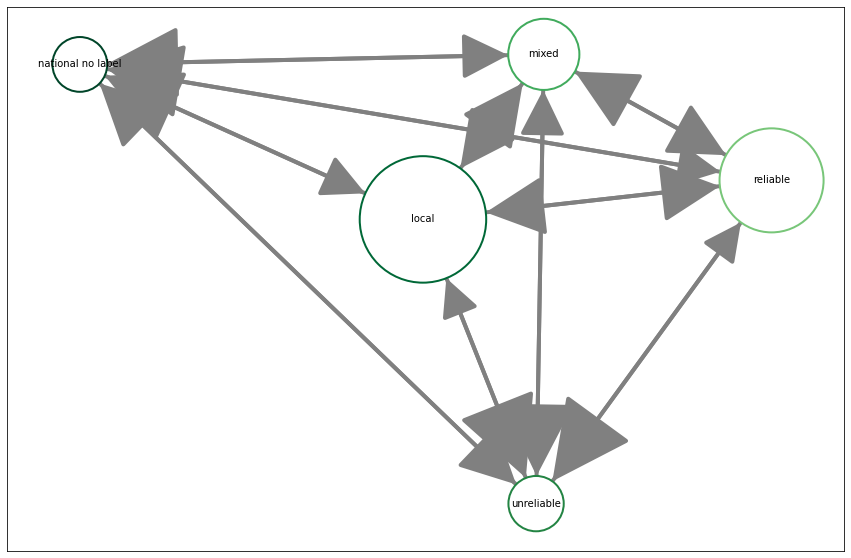

In [1211]:
fig, ax = plt.subplots(figsize=(15, 10))
pos = nx.spring_layout(G, seed=10, k=14)

edges = G.edges()

#get/scale weights 
weights = [G[u][v]['weight'] for u,v in edges]
weights = list(nx.get_edge_attributes(G,'weight').values())
ampWeights = [item for item in weights]
minWeight = min(ampWeights)
maxWeight = max(ampWeights)
scaledWeights = [((item - minWeight) / maxWeight)*8 for item in ampWeights]
scaledWeights = [(item*5) + 4 for item in normedWeights]

arrowWeights = [item * 20 for item in scaledWeights]

#get node sizes
FLOOR_SIZE = 3000
nodeSizes = list(nx.get_node_attributes(G, "outDiffs").values())
ampSizes = [(item - min(nodeSizes))**4 for item in nodeSizes]
scaledSizes = [(((item - min(ampSizes)) / max(ampSizes))*13000) + FLOOR_SIZE for item in ampSizes]

nodes = nx.draw_networkx_nodes(G, pos, node_size=scaledSizes, linewidths=2, node_color="white", edgecolors=nodeColors)

nx.draw_networkx_edges(G, pos, node_size=scaledSizes, width=4, arrowsize=arrowWeights, alpha=1, arrows=True, edge_color="grey")

nx.draw_networkx_labels(G, pos, font_size=10)

In [1212]:
infoFlows = []

#we want to try scaling the edges by their number of stories 
for edge in nx.edges(G): 
    thisEdge = G.edges[edge[0], edge[1]]["weight"]
    oppEdge = G.edges[edge[1], edge[0]]["weight"]
    newEdge = thisEdge - oppEdge
    if newEdge > 0: 
        infoFlows.append((edge[0], edge[1], newEdge))
    
Gflows = nx.create_empty_copy(G)

In [1213]:
Gflows.add_weighted_edges_from(infoFlows)

{'reliable': Text(0.3271715004768986, 0.042761823111485006, 'reliable'),
 'mixed': Text(-0.02409533152355096, 0.6037079078373125, 'mixed'),
 'unreliable': Text(0.972685208844884, -0.6370376194985636, 'unreliable'),
 'local': Text(-0.27576137779823157, 0.11422217175166219, 'local'),
 'national no label': Text(-1.0, -0.12365428320189595, 'national no label')}

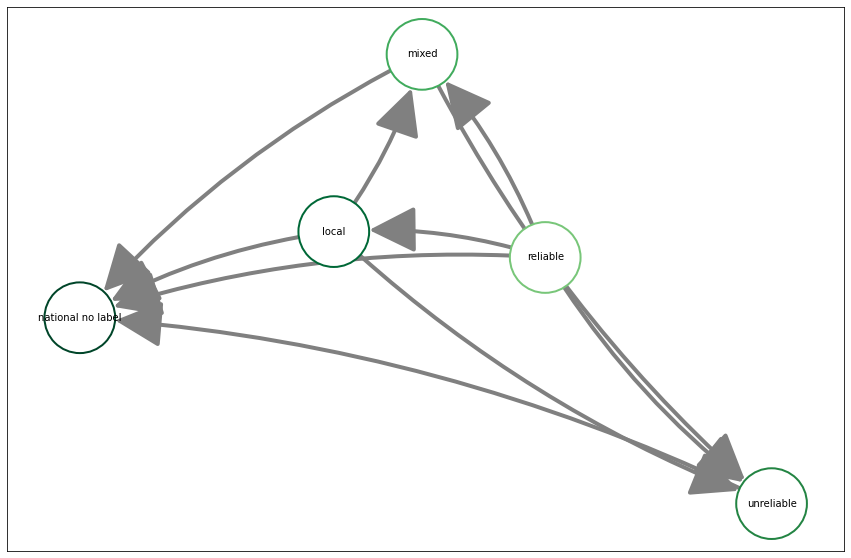

In [1214]:
fig, ax = plt.subplots(figsize=(15, 10))
pos = nx.spring_layout(Gflows, seed=10, k=14)

nodes = nx.draw_networkx_nodes(Gflows, pos, linewidths=2, node_size=5000, node_color="white", edgecolors=nodeColors)

nx.draw_networkx_edges(Gflows, pos, node_size=5000,  width=4, arrowsize=100, alpha=1,connectionstyle='arc3, rad=0.1', arrows=True, edge_color="grey")

nx.draw_networkx_labels(Gflows, pos, font_size=10)

In [1527]:
#how big exactly are the differences in these links? 
#we want to try scaling the edges by their number of stories 
for edge in nx.edges(G): 
    thisEdge = G.edges[edge[0], edge[1]]["weight"]
    oppEdge = G.edges[edge[1], edge[0]]["weight"]
    print(f"{edge[0]} - {edge[1]} = {thisEdge} - {oppEdge} = {thisEdge - oppEdge}")
    normedWeights.append(newEdge)

reliable - mixed = 16514 - 14126 = 2388
reliable - unreliable = 3708 - 2616 = 1092
reliable - local = 21933 - 18313 = 3620
reliable - national no label = 5768 - 4603 = 1165
mixed - reliable = 14126 - 16514 = -2388
mixed - unreliable = 6628 - 5588 = 1040
mixed - local = 31811 - 32434 = -623
mixed - national no label = 9217 - 8841 = 376
unreliable - reliable = 2616 - 3708 = -1092
unreliable - mixed = 5588 - 6628 = -1040
unreliable - local = 5701 - 7303 = -1602
unreliable - national no label = 1885 - 2092 = -207
local - reliable = 18313 - 21933 = -3620
local - mixed = 32434 - 31811 = 623
local - unreliable = 7303 - 5701 = 1602
local - national no label = 11418 - 10504 = 914
national no label - reliable = 4603 - 5768 = -1165
national no label - mixed = 8841 - 9217 = -376
national no label - unreliable = 2092 - 1885 = 207
national no label - local = 10504 - 11418 = -914


In [2014]:
#get united states graph 

#get local outlets   
#CUTOFF = 200
localList = list(sourceDf.loc[sourceDf["national"] == False, "source"]) 

#get all edges between top sources 
topEdgeDf = edgeDf[(edgeDf["first"].isin(localList)) & edgeDf["second"].isin(localList)]


In [2015]:
#merge in locations 
locDf = pd.read_csv("/shared/3/projects/newsDiffusion/data/raw/NELAdata/CSVs/outlets.csv", sep=",")[["source", "state"]]
locDf = locDf.drop_duplicates()

In [2016]:
len(locDf["state"].unique())

46

In [2017]:
#merge in locations 
topEdgeDf = pd.merge(topEdgeDf, locDf, left_on="first", right_on="source", how="left").drop(columns=["source"]).rename(columns={"state":"lState"})
topEdgeDf = pd.merge(topEdgeDf, locDf, left_on="second", right_on="source", how="left").drop(columns=["source"]).rename(columns={"state":"rState"})

In [2018]:
topEdgeDf = topEdgeDf[topEdgeDf["lState"] != topEdgeDf["rState"]]

In [2019]:
#get edges going out of state versus coming in 
outEdges = topEdgeDf[["lState", "weight"]].groupby(["lState"]).agg(sum).reset_index()

In [2020]:
inEdges = topEdgeDf[["rState",  "weight"]].groupby(["rState"]).agg(sum).reset_index()

In [2027]:
len(stormRows.loc[(stormRows["national"] == False), "state"].unique())

38

In [2028]:
len(inEdges)

37

In [2029]:
len(outEdges)

37

In [2030]:
stateEdges = pd.merge(outEdges, inEdges, left_on="lState", right_on="rState", how="outer")\
.rename(columns={"weight_x":"out_weight", "weight_y":"in_weight"})

In [2032]:
stateEdges["weightRatio"] = stateEdges["out_weight"] / stateEdges["in_weight"]
stateEdges["weightDifference"] = stateEdges["out_weight"] - stateEdges["in_weight"]

In [2033]:
import geopandas as gpd

In [2034]:
states = gpd.read_file("/home/blitt/reference/geospatial/shapeFiles/2022_census_states/tl_2022_us_state.shp")

In [2035]:
states.columns

Index(['REGION', 'DIVISION', 'STATEFP', 'STATENS', 'GEOID', 'STUSPS', 'NAME',
       'LSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'geometry'],
      dtype='object')

In [2044]:
distsMerged = pd.merge(states.rename(columns={"NAME":"state"}), stateEdges, left_on="state", right_on="lState",  how="left")

In [2045]:
distsMerged.columns

Index(['REGION', 'DIVISION', 'STATEFP', 'STATENS', 'GEOID', 'STUSPS', 'state',
       'LSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'geometry', 'lState', 'out_weight', 'rState', 'in_weight',
       'weightRatio', 'weightDifference'],
      dtype='object')

In [2046]:
#distsMerged["weightDifference"] = distsMerged["weightDifference"].apply(np.log)

Text(0.5, 212.7055695423244, '*Log scale')

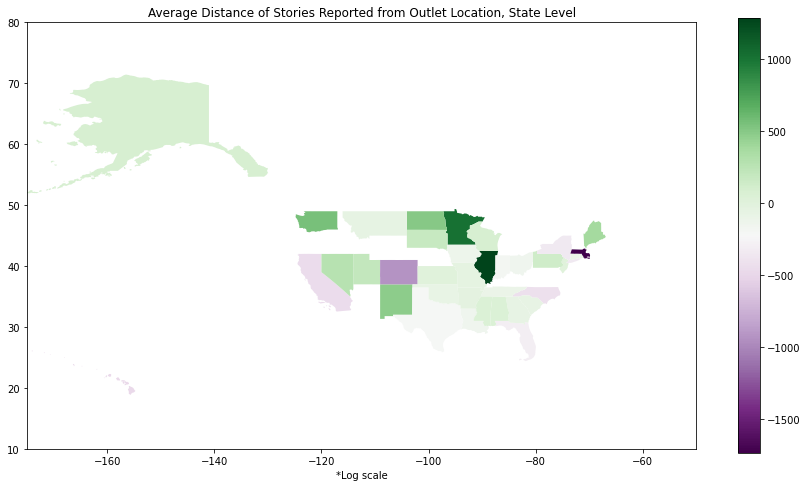

In [2047]:
fig, ax = plt.subplots(1, figsize=(15, 8))
distsMerged[["geometry", "weightDifference"]].plot(column="weightDifference", cmap="PRGn", linewidth=1, ax=ax, legend=True)

plt.xlim(-175, -50)
plt.ylim(10, 80)
plt.title("Average Distance of Stories Reported from Outlet Location, State Level")
plt.xlabel("*Log scale")

Text(0.5, 1.0, 'State-Level Ratio of Outgoing Influence Links to Incoming')

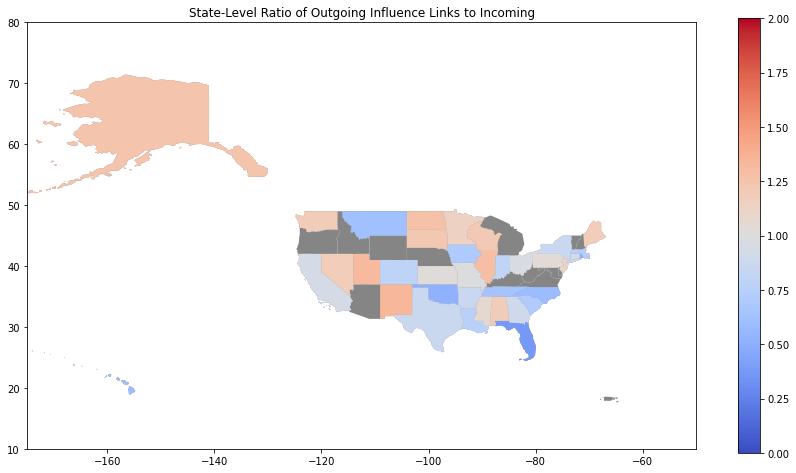

In [2060]:
from matplotlib import colors
divnorm=colors.TwoSlopeNorm(vmin=0, vcenter=1, vmax=2)
#pcolormesh(your_data, cmap="coolwarm", norm=divnorm)

fig, ax = plt.subplots(1, figsize=(15, 8))
distsMerged.plot(color="#858585", ax=ax)
distsMerged[["geometry", "weightRatio"]].plot(column="weightRatio", cmap="coolwarm", norm=divnorm, linewidth=1, ax=ax, legend=True)

plt.xlim(-175, -50)
plt.ylim(10, 80)
plt.title("State-Level Ratio of Outgoing Influence Links to Incoming")

NameError: name 'divNorm' is not defined